# DDIM Inpainting on MNIST
To Build a DDIM pipeline for center-hole inpainting: timestep-conditioned U-Net, DDIM sampling, hole-only PSNR/L1.  
**Goal:** Train on masked MNIST, then sample reconstructions and evaluate only inside the mask.  
Used **Google Colab (GPU)** and kept batch size modest to avoid OOM.


## 0. Prerequisites (Colab GPU)
- In Colab: **Runtime → Change runtime type → Hardware accelerator → GPU → Save**.
- CPU works but training will be **much slower**.
- This notebook installs only minimal packages.

> If you prefer Kaggle: enable GPU in **Settings → Accelerator → GPU**.

**Quick GPU check (run once):**
```python
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 1. Install minimal dependencies

- **For Colab:** PyTorch is already installed—**don’t reinstall `torch`/`torchvision`**. Install only extras below.  
- **Non-Colab users:** Use the pinned install shown after the Colab snippet.

**Colab (recommended):**
```bash
!pip -q install -U tqdm matplotlib


## 2. Check GPU

Run this cell to verify that CUDA is available (Colab GPU recommended):

```python
import torch, platform
print("Python:", platform.python_version())
print("PyTorch:", torch.__version__)
print("CUDA available?", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("Running on CPU — training will be much slower.")


## 3. Quick Equations (reference)

**Forward noising**
$$
x_t=\sqrt{\bar{\alpha}_t}\,x_0+\sqrt{1-\bar{\alpha}_t}\,\varepsilon,\qquad \varepsilon\sim\mathcal N(0,I)
$$

**Cosine schedule — beta\_t from abar(t)**
$$
\bar{\alpha}(t)=\cos^2\!\left(\frac{t/T+s}{1+s}\cdot\frac{\pi}{2}\right)
$$
$$
\beta_t=\min\!\left(0.999,\;1-\frac{\bar{\alpha}(t+1)}{\bar{\alpha}(t)}\right)
$$

**Prediction-space mapping**
- **pred = `eps`**
$$
\hat\varepsilon=\text{out},\qquad
\hat x_0=\frac{x_t-\sqrt{1-\bar{\alpha}_t}\,\hat\varepsilon}{\sqrt{\bar{\alpha}_t}}
$$

- **pred = `x0`**
$$
\hat x_0=\text{out},\qquad
\hat\varepsilon=\frac{x_t-\sqrt{\bar{\alpha}_t}\,\hat x_0}{\sqrt{1-\bar{\alpha}_t}}
$$

- **pred = `v`**
$$
\hat x_0=\sqrt{\bar{\alpha}_t}\,x_t-\sqrt{1-\bar{\alpha}_t}\,\text{out},\qquad
\hat\varepsilon=\sqrt{1-\bar{\alpha}_t}\,x_t+\sqrt{\bar{\alpha}_t}\,\text{out}
$$

**DDIM step** (optional noise eta)
$$
\sigma_t=\eta\cdot\sqrt{\frac{1-\bar{\alpha}_{t'}}{1-\bar{\alpha}_t}\left(1-\frac{\bar{\alpha}_t}{\bar{\alpha}_{t'}}\right)}
$$
$$
x_{t'}=\sqrt{\bar{\alpha}_{t'}}\,\hat x_0+\sqrt{1-\bar{\alpha}_{t'}-\sigma_t^{2}}\,\hat\varepsilon+\mathbf{1}_{\eta>0}\,\sigma_t z
$$


## 4. Utilities & Data 

Helper functions used throughout the notebook:
- **Repro & device:** `seed_all`, `dev`
- **I/O & viz:** `ensure_dir`, `save_grid`, `safe_torch_load`
- **Data:** `get_mnist_loader` (MNIST → 32×32, normalized to \([-1,1]\))
- **Masking:** `make_center_box_mask` (zeros at center box = hole)
- **Metrics (hole-only):** `psnr_on_mask`, `l1_on_mask`

> Note: `seed_all` sets `cudnn.benchmark=True` for speed (slightly non-deterministic). If you need **strict reproducibility**, temporarily set it to `False`.


In [2]:
import os, math, json, random
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils as vutils
from dataclasses import dataclass
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----------------------------
# Utils
# ----------------------------
def seed_all(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

def dev():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

def ensure_dir(p):
    os.makedirs(p, exist_ok=True); return p

def save_grid(x, path, nrow=8, rng=(-1,1), dpi=220):
    ensure_dir(os.path.dirname(path) or ".")
    grid = vutils.make_grid(x, nrow=nrow, normalize=True, value_range=rng)
    plt.figure(figsize=(5,5)); plt.axis("off")
    arr = grid.detach().cpu().numpy().transpose(1,2,0)
    if arr.shape[2] == 1:
        arr = np.repeat(arr, 3, axis=2)
    plt.imshow(arr); plt.tight_layout(); plt.savefig(path, dpi=dpi); plt.close()

def safe_torch_load(path, map_location="cpu"):
    try:
        return torch.load(path, map_location=map_location, weights_only=True)  # PyTorch ≥2.4
    except TypeError:
        return torch.load(path, map_location=map_location)

def get_mnist_loader(batch_size=128, num_workers=2):
    tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32,32), antialias=True),
        transforms.Normalize((0.5,), (0.5,)),  # [-1,1]
    ])
    tr = datasets.MNIST('./data', train=True,  transform=tfm, download=True)
    te = datasets.MNIST('./data', train=False, transform=tfm, download=True)
    train = DataLoader(tr, batch_size, shuffle=True,  num_workers=num_workers, drop_last=True)
    test  = DataLoader(te, batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
    return train, test, (1,32,32)

# ----------------------------
# Masks (centered, fixed size)
# ----------------------------
def make_center_box_mask(B, H, W, box=12):
    m = torch.ones(B,1,H,W)
    hs, ws = H//2, W//2
    h0, h1 = hs - box//2, hs + box//2
    w0, w1 = ws - box//2, ws + box//2
    m[:,:,h0:h1,w0:w1] = 0.0
    return m

# ----------------------------
# Metrics (hole region only)
# ----------------------------
@torch.no_grad()
def psnr_on_mask(pred, target, known_mask, eps=1e-8):
    hole = (1.0 - known_mask)
    N = hole.sum().clamp_min(1.0)
    p = (pred+1)/2; t = (target+1)/2
    mse = ((p - t)**2 * hole).sum() / N
    return float(10.0 * torch.log10(1.0 / (mse + eps)))

@torch.no_grad()
def l1_on_mask(pred, target, known_mask):
    hole = (1.0 - known_mask)
    N = hole.sum().clamp_min(1.0)
    return float(((pred - target).abs() * hole).sum() / N)

## 5. Model & Diffusion 

Here I implemented the core pieces of the model and sampler. Kept interfaces unchanged. Used the **Quick Equations** section above as reference.


In [3]:
def sinusoidal_embed(t: torch.Tensor, dim: int) -> torch.Tensor:
    r"""
    ### Implemented sinusoidal timestep embedding ϕ(t) ∈ ℝ^{B×dim}.

    Let H = ⌊dim/2⌋, and frequencies
      f_k = exp( - (log 10000) * k / max(1, H-1) ),  k = 0..H-1.

    Define
      ϕ(t) = [ sin(t f_0), ..., sin(t f_{H-1}),  cos(t f_0), ..., cos(t f_{H-1}) ].
    If dim is odd, append one zero column.

    Inputs:
      t: (B,) Long/float tensor (will cast to float internally)
      dim: embedding size
    Output:
      (B, dim) on same device as t.
    """
    t = t.float().unsqueeze(1)          # (B, 1)
    device = t.device

    # half of the channels are sin, half are cos
    H = dim // 2                        # floor(dim / 2)

    if H > 0:
        # k = 0 .. H-1
        k = torch.arange(H, device=device, dtype=torch.float32)

        # f_k = exp( - (log 10000) * k / max(1, H-1) )
        denom = max(1, H - 1)
        freqs = torch.exp(-math.log(10000.0) * k / denom)   # (H,)

        # broadcast t over frequencies: (B, 1) * (1, H) -> (B, H)
        angles = t * freqs.unsqueeze(0)

        # [ sin(t f_k), cos(t f_k) ]
        emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=1)  # (B, 2H)
    else:
        # degenerate case if dim == 0 or 1
        emb = torch.zeros(t.shape[0], 0, device=device)

    # if dim is odd, pad one extra zero channel (or more, just in case)
    if emb.shape[1] < dim:
        pad = torch.zeros(t.shape[0], dim - emb.shape[1], device=device)
        emb = torch.cat([emb, pad], dim=1)

    return emb

class ResBlock(nn.Module):
    r"""
    ### Residual block with time embedding injection

    Given input x ∈ ℝ^{B×C×H×W} and time embedding e ∈ ℝ^{B×E},
    compute:
      h = x + MLP(e)[:, :, None, None]
      h = GN(C) → SiLU → Conv2d(C→C, 3×3, s=1, p=1)
      h = Dropout2d(p=dropout)
      h = GN(C) → SiLU → Conv2d(C→C, 3×3, s=1, p=1)
      out = x + h

    Use GroupNorm with 'groups' (cap to divisors of C; at least 1).
    """
    def __init__(self, ch: int, emb: int, dropout: float=0.1, groups: int=8):
        super().__init__()

        # choose a valid number of groups for GroupNorm (must divide ch)
        g = min(groups, ch)
        while ch % g != 0 and g > 1:
            g -= 1
        if g <= 0:
            g = 1

        self.norm1 = nn.GroupNorm(num_groups=g, num_channels=ch)
        self.norm2 = nn.GroupNorm(num_groups=g, num_channels=ch)
        self.act = nn.SiLU()

        self.conv1 = nn.Conv2d(ch, ch, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(ch, ch, kernel_size=3, stride=1, padding=1)

        self.dropout = nn.Dropout2d(p=dropout)

        # ***This is the "MLP": a single linear projection emb -> ch.***
        self.time_proj = nn.Linear(emb, ch)


    def forward(self, x: torch.Tensor, e: torch.Tensor) -> torch.Tensor:

        # project time embedding and broadcast over spatial dims
        temb = self.time_proj(e)          # (B, ch)
        temb = temb[:, :, None, None]     # (B, ch, 1, 1)

        # add time bias to the feature map before the conv stack
        h = x + temb
        h = self.conv1(self.act(self.norm1(h)))
        h = self.dropout(h)
        h = self.conv2(self.act(self.norm2(h)))

        # standard residual connection
        return x + h


class SelfAttention2d(nn.Module):
    r"""
    ### Single-head self-attention at spatial resolution (e.g., 8×8).

    Normalize with GroupNorm(8, C).
    Compute q,k,v via 1×1 convs (C→C).
    Shapes:
      x: (B,C,H,W)
      q: (B,HW,C)   from (B,C,H,W) → (B,C,HW) → (B,HW,C)
      k: (B,C,HW)
      v: (B,HW,C)
      attn = softmax( (q @ k)/√C , dim=-1 )   → (B,HW,HW)
      out  = (attn @ v) → (B,HW,C) → (B,C,H,W) → proj 1×1 → residual add.
    """

    def __init__(self, ch: int, groups: int = 8):
        super().__init__()
        self.norm = nn.GroupNorm(8, ch)
        self.q_proj = nn.Conv2d(ch, ch, 1)
        self.k_proj = nn.Conv2d(ch, ch, 1)
        self.v_proj = nn.Conv2d(ch, ch, 1)
        self.out_proj = nn.Conv2d(ch, ch, 1)

    def forward(self, x):

        # x: (B, C, H, W)
        h = self.norm(x)
        B, C, H, W = h.shape
        N = H * W

        q = self.q_proj(h).view(B, C, N).transpose(1, 2)  # (B, N, C)
        k = self.k_proj(h).view(B, C, N)                  # (B, C, N)
        v = self.v_proj(h).view(B, C, N).transpose(1, 2)  # (B, N, C)

        # NOTE: divide by C, not sqrt(C), to match qk^T / C in the doc
        attn = torch.bmm(q, k) / float(C)                 # (B, N, N)
        attn = torch.softmax(attn, dim=-1)

        out = torch.bmm(attn, v)                          # (B, N, C)
        out = out.transpose(1, 2).view(B, C, H, W)        # (B, C, H, W)
        out = self.out_proj(out)

        return x + out

class UNetDeep(nn.Module):
    r"""
    ### Implemented the UNet backbone with time-conditioning and mid attention.

    Input channels depend on flags:
      - Base: [x_t, m, y] → 3 channels
      - + self-conditioning: add x0_sc → +1 channel (total 4)
      - + coord_conv: add (coord_x, coord_y) → +2 channels (total 5 or 6)

    Spec (assume base=B):
      t-MLP: Linear(E→2E) → SiLU → Linear(2E→E)
      Down:
        inp:  Conv2d(in_ch→B, 3×3,1,1)
        rb0:  ResBlock(B,E)
        d1 :  Conv2d(B→2B, 4×4,2,1)
        rb1:  ResBlock(2B,E)
        d2 :  Conv2d(2B→4B, 4×4,2,1)
        rb2:  ResBlock(4B,E)
      Mid (8×8):
        mid1: ResBlock(4B,E)
        attn: SelfAttention2d(4B)
        mid2: ResBlock(4B,E)
      Up:
        u1 :  ConvTranspose2d(4B→2B, 4×4,2,1)
        red1: Conv2d(2B+2B→2B, 1×1)
        rb3:  ResBlock(2B,E)
        u2 :  ConvTranspose2d(2B→B, 4×4,2,1)
        red2: Conv2d(B+B→B, 1×1)
        rb4:  ResBlock(B,E)
      Out:
        Conv2d(B→1, 3×3,1,1)
    """
    def __init__(self, in_ch=3, base=96, emb=384, out_ch=1, dropout=0.1, use_attn=True):
        super().__init__()

        self.in_ch = in_ch
        self.base = base
        self.emb_dim = emb
        self.out_ch = out_ch
        self.use_attn = use_attn

        B = base
        E = emb

        # ---- time MLP: Linear(E→2E) → SiLU → Linear(2E→E) ----
        self.time_mlp = nn.Sequential(
            nn.Linear(E, 2 * E),
            nn.SiLU(),
            nn.Linear(2 * E, E),
        )

        # ----------------- Down path -----------------
        # 32x32
        self.inp = nn.Conv2d(in_ch, B, kernel_size=3, stride=1, padding=1)
        self.rb0 = ResBlock(B, E, dropout=dropout)

        # 32x32 -> 16x16
        self.d1  = nn.Conv2d(B, 2 * B, kernel_size=4, stride=2, padding=1)
        self.rb1 = ResBlock(2 * B, E, dropout=dropout)

        # 16x16 -> 8x8
        self.d2  = nn.Conv2d(2 * B, 4 * B, kernel_size=4, stride=2, padding=1)
        self.rb2 = ResBlock(4 * B, E, dropout=dropout)

        # ----------------- Mid (8x8) -----------------
        self.mid1 = ResBlock(4 * B, E, dropout=dropout)
        self.mid_attn = SelfAttention2d(4 * B) if use_attn else nn.Identity()
        self.mid2 = ResBlock(4 * B, E, dropout=dropout)

        # ----------------- Up path -----------------
        # 8x8 -> 16x16
        self.u1   = nn.ConvTranspose2d(4 * B, 2 * B, kernel_size=4, stride=2, padding=1)
        self.red1 = nn.Conv2d(2 * B + 2 * B, 2 * B, kernel_size=1)  # (4B→2B)
        self.rb3  = ResBlock(2 * B, E, dropout=dropout)

        # 16x16 -> 32x32
        self.u2   = nn.ConvTranspose2d(2 * B, B, kernel_size=4, stride=2, padding=1)
        self.red2 = nn.Conv2d(B + B, B, kernel_size=1)              # (2B→B)
        self.rb4  = ResBlock(B, E, dropout=dropout)

        # ----------------- Output -----------------
        self.out = nn.Conv2d(B, out_ch, kernel_size=3, stride=1, padding=1)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # ====== Implement here ======
        t_embed = sinusoidal_embed(t, self.emb_dim)
        t_feat  = self.time_mlp(t_embed)

        # ----- Down -----
        h0 = self.inp(x)           # (B, B, 32, 32)
        h0 = self.rb0(h0, t_feat)  # skip0

        h1 = self.d1(h0)           # (B, 2B, 16, 16)
        h1 = self.rb1(h1, t_feat)  # skip1

        h2 = self.d2(h1)           # (B, 4B, 8, 8)
        h2 = self.rb2(h2, t_feat)

        # ----- Mid -----
        h = self.mid1(h2, t_feat)
        h = self.mid_attn(h)
        h = self.mid2(h, t_feat)

        # ----- Up -----
        # 8x8 -> 16x16
        u1 = self.u1(h)                  # (B, 2B, 16, 16)
        u1 = torch.cat([u1, h1], dim=1)  # (B, 4B, 16, 16)
        u1 = self.red1(u1)               # (B, 2B, 16, 16)
        u1 = self.rb3(u1, t_feat)

        # 16x16 -> 32x32
        u2 = self.u2(u1)                 # (B, B, 32, 32)
        u2 = torch.cat([u2, h0], dim=1)  # (B, 2B, 32, 32)
        u2 = self.red2(u2)               # (B, B, 32, 32)
        u2 = self.rb4(u2, t_feat)

        # final prediction (eps/x0/v depending on training config)
        out = self.out(u2)               # (B, out_ch, 32, 32)
        return out


# ----------------------------
# Diffusion core (buffers + forward noising)
# ----------------------------
from dataclasses import dataclass
@dataclass
class DCfg:
    steps:int=400
    beta_start:float=1e-4
    beta_end:float=2e-2
    beta_schedule:str="cosine"  # {'linear','cosine'}

def cosine_betas(T: int, s: float = 0.008) -> torch.Tensor:
    r"""
    ### Implemented cosine β_t from ᾱ(t)

    ᾱ(t) = cos^2( ((t/T + s)/(1+s)) * π/2 ), for t in {0,...,T}
    Then:
      β_t = min(0.999, 1 - ᾱ(t+1)/ᾱ(t))   for t = 0..T-1
    Return float32 tensor shape (T,)
    """

    # we build alpha_bar at T+1 points: t = 0, 1, ..., T
    steps = T + 1
    t = torch.linspace(0, T, steps, dtype=torch.float64) / T  # (T+1,)

    # alpha_bar(t) = cos^2( ((t + s)/(1 + s)) * pi/2 )
    f = (t + s) / (1.0 + s)
    alpha_bar = torch.cos(f * math.pi / 2) ** 2  # (T+1,)

    # normalize so that alpha_bar[0] is exactly 1
    alpha_bar = alpha_bar / alpha_bar[0]

    # betas_t = 1 - alpha_bar_{t+1} / alpha_bar_t
    betas = 1.0 - (alpha_bar[1:] / alpha_bar[:-1])  # (T,)

    # clamp for numerical stability
    betas = torch.clamp(betas, min=1e-8, max=0.999)

    return betas.float()

class Diffusion:
    def __init__(self, cfg: DCfg):
        r"""
        ### Build buffers from β_t
          α_t       = 1 - β_t
          ᾱ_t      = ∏_{s=1}^t α_s
          sqrt_ab   = √(ᾱ_t)
          sqrt_1mab = √(1 - ᾱ_t)
          sqrt_ra   = √(1/α_t)
          post_var  = β_t * (1 - ᾱ_{t-1}) / (1 - ᾱ_t)   with ᾱ_0 = 1
        """
        self.cfg = cfg
        T = cfg.steps
        self.T = T

        # chosen beta schedule 
        if cfg.beta_schedule == "cosine":
            # cosine schedule ignores beta_start/beta_end and uses the ᾱ(t) formula
            betas = cosine_betas(T)  # (T,)
        elif cfg.beta_schedule == "linear":
            # simple linear schedule from beta_start to beta_end
            betas = torch.linspace(cfg.beta_start, cfg.beta_end, T, dtype=torch.float32)
            betas = torch.clamp(betas, 1e-8, 0.999)
        else:
            raise ValueError(f"Unknown beta_schedule: {cfg.beta_schedule}")

        betas = betas.to(torch.float32)

        # α_t = 1 - β_t
        alphas = 1.0 - betas

        # ᾱ_t = Π_{s=0}^t α_s  (0-based indexing)
        a_bar = torch.cumprod(alphas, dim=0)                     # (T,)

        # ᾱ_{t-1} with ᾱ_{-1} ≡ 1  → a_bar_prev[0] = 1
        a_bar_prev = torch.cat(
            [torch.ones(1, dtype=a_bar.dtype), a_bar[:-1]],
            dim=0
        )  # (T,)

        # store buffers
        self.betas      = betas                # β_t
        self.alphas     = alphas               # α_t
        self.a_bar      = a_bar                # ᾱ_t
        self.sqrt_ab    = torch.sqrt(a_bar)    # √ᾱ_t
        self.sqrt_1mab  = torch.sqrt(1.0 - a_bar)     # √(1-ᾱ_t)
        self.sqrt_ra    = torch.sqrt(1.0 / alphas)    # √(1/α_t)

        # posterior variance β̃_t = β_t * (1 - ᾱ_{t-1}) / (1 - ᾱ_t)
        denom = 1.0 - a_bar
        self.post_var = betas * (1.0 - a_bar_prev) / (denom + 1e-8)

    def to_(self, d: torch.device):
        for k,v in vars(self).items():
            if isinstance(v, torch.Tensor):
                setattr(self, k, v.to(d))
        return self

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: torch.Tensor=None):
        r"""
        ### Forward noising
          x_t = √(ᾱ_t) * x0 + √(1 - ᾱ_t) * ε,   ε~N(0,I)
        Return (x_t, ε). Use provided ε if not None.
        """
        # x0: (B, 1, 32, 32) in [-1, 1]
        # t : (B,) integer timesteps in [0, T-1]

        if eps is None:
            eps = torch.randn_like(x0)  # fresh Gaussian noise

        # gather √ᾱ_t and √(1-ᾱ_t) for the batch timesteps
        # self.sqrt_ab, self.sqrt_1mab are (T,) with 0-based indexing
        sqrt_ab_t   = self.sqrt_ab[t].view(-1, 1, 1, 1)     # (B,1,1,1)
        sqrt_1mab_t = self.sqrt_1mab[t].view(-1, 1, 1, 1)   # (B,1,1,1)

        # closed-form noising
        x_t = sqrt_ab_t * x0 + sqrt_1mab_t * eps

        return x_t, eps


# ----------------------------
# EMA 
# ----------------------------
class EMA:
    def __init__(self, model: nn.Module, decay=0.999):
        self.decay = decay
        self.shadow = {k: v.detach().clone() for k,v in model.state_dict().items()}
    @torch.no_grad()
    def update(self, model: nn.Module):
        for k, v in model.state_dict().items():
            if v.dtype.is_floating_point:
                self.shadow[k].mul_(self.decay).add_(v, alpha=1.0 - self.decay)
            else:
                self.shadow[k] = v.detach().clone()
    def copy_to(self, model: nn.Module):
        model.load_state_dict(self.shadow, strict=True)


# ----------------------------
# Pred space helpers & DDIM step
# ----------------------------
def to_eps_from_pred(pred_type, out, xt, sqrt_ab_t, sqrt_1mab_t):
    r"""
    ### Map network output 'out' to (ε̂, x̂0) depending on prediction space.

      If pred_type == 'eps':
        ε̂   = out
        x̂0  = (xt - √(1-ᾱ_t)*ε̂)/√(ᾱ_t)
      If pred_type == 'x0':
        x̂0  = out
        ε̂   = (xt - √(ᾱ_t)*x̂0)/√(1-ᾱ_t)

      If pred_type == 'v':
        x̂0  = √(ᾱ_t)*xt - √(1-ᾱ_t)*out
        ε̂   = √(1-ᾱ_t)*xt + √(ᾱ_t)*out
    """

    if pred_type == "eps":
        # network directly predicts the noise
        eps_hat = out
        x0_hat = (xt - sqrt_1mab_t * eps_hat) / (sqrt_ab_t + 1e-8)

    elif pred_type == "x0":
        # network directly predicts the clean image
        x0_hat = out
        eps_hat = (xt - sqrt_ab_t * x0_hat) / (sqrt_1mab_t + 1e-8)

    elif pred_type == "v":
        # v-prediction: out is a combo of x0 and eps
        x0_hat = sqrt_ab_t * xt - sqrt_1mab_t * out
        eps_hat = sqrt_1mab_t * xt + sqrt_ab_t * out

    else:
        raise ValueError(f"Unknown pred_type: {pred_type}")

    return eps_hat, x0_hat

@torch.no_grad()
def ddim_p_step(net, dd, x_t, m, y, t, t_prev, pred_type="v", self_cond=False, x0_sc=None, eta=0.0, coord_conv=False):
    r"""
    ### DDIM deterministic step (η=0) with optional noise (η>0):
      ā_t = ᾱ_t, ā_{t'} = ᾱ_{t_prev} [or 1 if t_prev=None]
      σ_t = η * sqrt( (1 - ā_{t'})/(1 - ā_t) * (1 - ā_t / ā_{t'}) )
      x_{t'} = √(ā_{t'}) * x̂0 + √(1 - ā_{t'} - σ_t^2) * ε̂  + 1_{η>0} * σ_t * z

    Inputs include conditioning channels [x_t, m, y, (x0_sc), (coords?)].
    Return (x_{t'}, x̂0).
    """

    device = x_t.device
    B, _, H, W = x_t.shape

    # ----- coord-conv channels -----
    coords = None
    if coord_conv:
        yy, xx = torch.meshgrid(
            torch.linspace(-1.0, 1.0, H, device=device),
            torch.linspace(-1.0, 1.0, W, device=device),
            indexing="ij",
        )
        coords = torch.stack([xx, yy], dim=0).expand(B, -1, -1, -1)  # (B,2,H,W)

    # ----- build input to UNet -----
    if self_cond:
        if x0_sc is None:
            sc = torch.zeros_like(y)
        else:
            sc = x0_sc
        din = [x_t, m, y, sc]
    else:
        din = [x_t, m, y]

    if coords is not None:
        din.append(coords)

    out = net(torch.cat(din, dim=1), t)  # net prediction in chosen space

    # ----- map to (eps_hat, x0_hat) -----
    sqrt_ab_t   = dd.sqrt_ab[t].view(-1, 1, 1, 1)
    sqrt_1mab_t = dd.sqrt_1mab[t].view(-1, 1, 1, 1)
    eps_hat, x0_hat = to_eps_from_pred(pred_type, out, x_t, sqrt_ab_t, sqrt_1mab_t)

    # ----- get ā_t and ā_{t'} -----
    a_bar_t = dd.a_bar[t]                      # (B,)

    if t_prev is None:
        # final step: treat ā_{t'} as 1
        a_bar_prev = torch.ones_like(a_bar_t)
    else:
        # t_prev is a scalar index from tau
        if isinstance(t_prev, torch.Tensor):
            t_prev_idx = t_prev.item()
        else:
            t_prev_idx = int(t_prev)
        a_bar_prev_scalar = dd.a_bar[t_prev_idx]          # scalar
        a_bar_prev = a_bar_prev_scalar.expand_as(a_bar_t) # (B,)

    a_bar_t   = a_bar_t.view(-1, 1, 1, 1)       # (B,1,1,1)
    a_bar_prev = a_bar_prev.view(-1, 1, 1, 1)   # (B,1,1,1)

    # ----- compute σ_t -----
    one = torch.ones_like(a_bar_t)
    # (1 - ā_{t'})/(1 - ā_t)
    ratio = (one - a_bar_prev) / (one - a_bar_t + 1e-8)
    # (1 - ā_t / ā_{t'})
    inner = ratio * (one - a_bar_t / (a_bar_prev + 1e-8))
    inner = torch.clamp(inner, min=0.0)
    sigma_t = eta * torch.sqrt(inner)

    # ----- DDIM x_{t'} update -----
    sqrt_a_bar_prev = torch.sqrt(a_bar_prev)
    coeff_eps = torch.sqrt(torch.clamp(one - a_bar_prev - sigma_t**2, min=0.0))

    if eta > 0.0:
        z = torch.randn_like(x_t)
    else:
        z = torch.zeros_like(x_t)

    x_t_prev = sqrt_a_bar_prev * x0_hat + coeff_eps * eps_hat + sigma_t * z

    # x0_hat is used for self-conditioning in the next step
    return x_t_prev, x0_hat.detach()

@torch.no_grad()
def enforce_known(dd, x_t, y, m, t, z_fixed=None):
    r"""
    Per-step data-consistency on known pixels (m=1):
      y_t = √(ᾱ_t) * y + √(1-ᾱ_t) * z_t
      x_t ← m ⊙ y_t  +  (1-m) ⊙ x_t
    If z_fixed is provided, reuse it; otherwise use zeros for stability.
    """
    z = torch.zeros_like(y) if z_fixed is None else z_fixed
    y_t = dd.sqrt_ab[t].view(-1,1,1,1) * y + dd.sqrt_1mab[t].view(-1,1,1,1) * z
    return m * y_t + (1.0 - m) * x_t


## 6. Loss & Inference 

Implements training loss and the DDIM inpainting sampler used at test time.

- **`p2_weight(a_bar_t, k, gamma)`** — SNR-based P2 reweighting for timestep-balanced training.
- **`loss_fn(net, dd, x0, m, y, t, ...)`** — Trains in chosen prediction space (`eps` / `x0` / `v`), uses `dd.q_sample` to form `(x_t, ε)`, optional **self-conditioning** and **coord-conv**, pixelwise **L2** with **hole upweighting** via `hole_weight`, and multiplies by **P2** weights; returns the mean loss.
- **`inpaint(net, dd, y, m, ...)`** — DDIM inpainting loop over a timestep grid; supports deterministic (`η=0`) or noisy (`η>0`) updates, optional `init_from_y`, per-step **data consistency** via `enforce_known` repeated `dc_repeats` times, optional fixed noise for DC, and optional self-conditioning across steps.

Keep the sampler `pred_type` consistent with training. Lower `steps` if memory is tight; `dc_repeats=2` often improves seam quality; use `η=0` for classic DDIM.


In [4]:
def p2_weight(a_bar_t, k=1.0, gamma=1.0):
    snr = a_bar_t / (1.0 - a_bar_t + 1e-8)
    return torch.pow(k + snr, -gamma)

def loss_fn(net, dd, x0, m, y, t, pred_type="v", hole_weight=5.0, p2_k=1.0, p2_gamma=1.0,
            self_cond=False, coord_conv=False):
    """
    Training loss (noise prediction in chosen space) with hole upweight + p2.
    """
    xt, eps = dd.q_sample(x0, t)
    B, _, H, W = x0.shape

    # coord-conv channels
    coords = None
    if coord_conv:
        yy, xx = torch.meshgrid(
            torch.linspace(-1, 1, H, device=x0.device),
            torch.linspace(-1, 1, W, device=x0.device),
            indexing="ij"
        )
        coords = torch.stack([xx, yy], dim=0).expand(B, -1, -1, -1)  # (B,2,H,W)

    # self-conditioning (50%): zero-SC prepass to get x0_sc
    if self_cond and (random.random() < 0.5):
        din0 = [xt, m, y, torch.zeros_like(x0)]
        if coords is not None: din0.append(coords)
        out0 = net(torch.cat(din0, dim=1), t)
        sqrt_ab_t   = dd.sqrt_ab[t].view(-1,1,1,1)
        sqrt_1mab_t = dd.sqrt_1mab[t].view(-1,1,1,1)
        _, x0_hat0 = to_eps_from_pred(pred_type, out0, xt, sqrt_ab_t, sqrt_1mab_t)
        sc = x0_hat0.detach()
        din = [xt, m, y, sc]
    else:
        din = [xt, m, y] + ([torch.zeros_like(x0)] if self_cond else [])

    if coords is not None:
        din.append(coords)

    out = net(torch.cat(din, dim=1), t)

    # target in chosen pred space
    if pred_type == "eps":
        target = eps
    elif pred_type == "x0":
        target = x0
    else:  # 'v'
        target = dd.sqrt_ab[t].view(-1,1,1,1) * eps - dd.sqrt_1mab[t].view(-1,1,1,1) * x0

    # pixelwise L2 with hole upweight + p2 weighting
    per_pix = (out - target)**2
    if hole_weight and hole_weight != 1.0:
        weight_mask = 1.0 + (hole_weight - 1.0) * (1.0 - m)
        per_pix = per_pix * weight_mask

    w = p2_weight(dd.a_bar[t], k=p2_k, gamma=p2_gamma).view(-1,1,1,1)
    return (w * per_pix).mean()


@torch.no_grad()
def inpaint(net, dd, y, m, steps=50, d=None, dc_repeats=2, dc_fixed_z=True,
            pred_type="v", self_cond=False, init_from_y=True,
            eta=0.0, coord_conv=False):
    device = y.device
    tau = torch.linspace(0, dd.T - 1, steps, device=device).round().long()
    B = y.size(0)
    if init_from_y:
        x = m * y + (1.0 - m) * torch.randn_like(y)
    else:
        x = torch.randn_like(y)
    z0 = torch.randn_like(y) if dc_fixed_z else None
    x0_sc = None

    for i in reversed(range(len(tau))):
        ti = tau[i]; tb = ti.repeat(B)
        for _ in range(max(1, dc_repeats)):
            x = enforce_known(dd, x, y, m, tb, z_fixed=z0)

        t_prev = tau[i-1] if i > 0 else None
        x, x0_sc = ddim_p_step(net, dd, x, m, y, tb, t_prev, pred_type=pred_type,
                               self_cond=self_cond, x0_sc=x0_sc, eta=eta, coord_conv=coord_conv)
    x = m * y + (1.0 - m) * x
    return x.clamp(-1,1)


## 7. Train / Sample / Eval helpers 

High-level helpers to **train**, **sample**, and **evaluate** without CLI flags.

- **`train(...)`** — Runs full training with AdamW, LR **warmup**, **EMA** tracking, optional **grad accumulation** & **grad clipping**. Periodically saves **inpainting panels** (`outputs/inpaint/panel_*.png`) using the EMA copy, and finally writes a checkpoint to `outputs/inpaint/last.pt` (with config).
- **`sample_cmd(...)`** — Loads the checkpoint (prefers **EMA** weights), rebuilds diffusion and UNet from saved config, inpaints a test batch, and saves `outputs/inpaint/samples.png`.
- **`eval_cmd(...)`** — Loads the checkpoint (prefers **EMA**), inpaints the MNIST test set up to `n_eval` images, computes **hole-only PSNR/L1**, and writes `results/inpaint_metrics.json`.

> **Heads-up:**  
> • Keep `pred` consistent between training and sampling.  
> • If memory is tight, lower `batch_size`, raise `grad_accum`, or reduce `steps/sample_steps`.  
> • Outputs are saved under `outputs/inpaint/` and metrics under `results/`.


In [5]:
def train(epochs=3, batch_size=128, lr=2e-4, steps=400,
          beta_start=1e-4, beta_end=2e-2, beta_schedule="cosine",
          base=96, emb=384, sample_every=400, sample_steps=50,
          center_box=12, dc_repeats=2, dc_fixed_z=True,
          pred="v", p2_k=1.0, p2_gamma=1.0, hole_weight=5.0,
          seed=42, clip_grad=1.0, ema_decay=0.999, warmup_steps=1000,
          self_cond=True, eta=0.0, coord_conv=True,
          grad_accum:int=1):
    seed_all(seed); d = dev()
    train_loader, test_loader, (C,H,W) = get_mnist_loader(batch_size=batch_size, num_workers=2)

    in_extra = (1 if self_cond else 0) + (2 if coord_conv else 0)
    in_ch = 3 + in_extra
    net = UNetDeep(in_ch=in_ch, base=base, emb=emb, out_ch=1, dropout=0.1, use_attn=True).to(d)

    dd = Diffusion(DCfg(steps=steps, beta_start=beta_start, beta_end=beta_end,
                        beta_schedule=beta_schedule)).to_(d)

    opt = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-4)
    ema = EMA(net, decay=ema_decay)

    step_i = 0
    scaler = 1.0 / max(1, grad_accum)
    for ep in range(epochs):
        running = 0.0
        for it,(x,_) in enumerate(tqdm(train_loader, desc=f"Epoch {ep+1}/{epochs}")):
            x = x.to(d)
            B = x.size(0)
            m = make_center_box_mask(B,H,W, box=center_box).to(d)
            y = m * x
            t = torch.randint(0, steps, (B,), device=d, dtype=torch.long)

            if warmup_steps and step_i < warmup_steps:
                warm_lr = lr * float(step_i + 1) / float(warmup_steps)
                for pg in opt.param_groups: pg["lr"] = warm_lr

            loss = loss_fn(net, dd, x, m, y, t,
                           pred_type=pred, hole_weight=hole_weight,
                           p2_k=p2_k, p2_gamma=p2_gamma, self_cond=self_cond,
                           coord_conv=coord_conv)
            (loss * scaler).backward()
            running += loss.detach().item()

            if ((it + 1) % grad_accum) == 0:
                if clip_grad and clip_grad > 0:
                    nn.utils.clip_grad_norm_(net.parameters(), max_norm=clip_grad)
                opt.step(); opt.zero_grad(); ema.update(net)
                step_i += 1

                if (step_i % sample_every) == 0:
                    with torch.no_grad():
                        net_ema = UNetDeep(in_ch=in_ch, base=base, emb=emb, out_ch=1).to(d)
                        ema.copy_to(net_ema); net_ema.eval()
                        idx = slice(0, min(16, B))
                        comp = inpaint(net_ema, dd, y[idx], m[idx], steps=sample_steps, d=d,
                                       dc_repeats=dc_repeats, dc_fixed_z=dc_fixed_z,
                                       pred_type=pred, self_cond=self_cond, init_from_y=True,
                                       eta=eta, coord_conv=coord_conv)
                        panel = torch.cat([x[idx], y[idx], comp], dim=0)
                        save_grid(panel, f"outputs/inpaint/panel_{step_i:06d}.png", nrow=panel.size(0)//3)
                        del net_ema

        print(f"[Epoch {ep+1}] mean loss: {running / max(1,len(train_loader)):.4f}")

    ensure_dir("outputs/inpaint")
    torch.save({
        "net": net.state_dict(),
        "ema": ema.shadow,
        "cfg": dict(epochs=epochs, batch_size=batch_size, lr=lr, steps=steps,
                    beta_start=beta_start, beta_end=beta_end, beta_schedule=beta_schedule,
                    base=base, emb=emb, sample_every=sample_every, sample_steps=sample_steps,
                    center_box=center_box, dc_repeats=dc_repeats, dc_fixed_z=dc_fixed_z,
                    pred=pred, p2_k=p2_k, p2_gamma=p2_gamma, hole_weight=hole_weight,
                    seed=seed, clip_grad=clip_grad, ema_decay=ema_decay, warmup_steps=warmup_steps,
                    self_cond=int(self_cond), eta=eta, coord_conv=int(coord_conv),
                    grad_accum=grad_accum)},
               "outputs/inpaint/last.pt")

    # Final panel with EMA
    with torch.no_grad():
        _, test_loader, _ = get_mnist_loader(batch_size=16, num_workers=0)
        x,_ = next(iter(test_loader))
        x = x.to(d); B = min(16, x.size(0))
        m = make_center_box_mask(B,32,32, box=center_box).to(d)
        y = m * x[:B]
        net_ema = UNetDeep(in_ch=in_ch, base=base, emb=emb, out_ch=1).to(d)
        pkg = safe_torch_load("outputs/inpaint/last.pt", map_location="cpu")
        state = pkg.get("ema", pkg.get("net"))
        net_ema.load_state_dict(state, strict=False)
        net_ema.eval()
        comp = inpaint(net_ema, dd, y, m, steps=sample_steps, d=d,
                       dc_repeats=dc_repeats, dc_fixed_z=dc_fixed_z,
                       pred_type=pred, self_cond=self_cond, init_from_y=True,
                       eta=eta, coord_conv=coord_conv)
        panel = torch.cat([x[:B], y, comp], dim=0)
        save_grid(panel, "outputs/inpaint/panel_final.png", nrow=B)


@torch.no_grad()
def sample_cmd(ckpt="outputs/inpaint/last.pt", n=16, steps=50,
               center_box=12, dc_repeats=2, dc_fixed_z=True,
               pred="v", self_cond=True, init_from_y=True,
               eta=0.0, coord_conv=True):
    d = dev()
    pkg = safe_torch_load(ckpt, map_location="cpu")
    cfg = pkg.get("cfg", {})
    base = cfg.get("base", 96); emb = cfg.get("emb", 384)
    dd = Diffusion(DCfg(steps=cfg.get("steps", steps),
                        beta_start=cfg.get("beta_start", 1e-4),
                        beta_end=cfg.get("beta_end", 2e-2),
                        beta_schedule=cfg.get("beta_schedule","cosine"))).to_(d)
    in_extra = (1 if int(cfg.get("self_cond", 1)) else 0) + (2 if int(cfg.get("coord_conv", 1)) else 0)
    in_ch = 3 + in_extra
    net = UNetDeep(in_ch=in_ch, base=base, emb=emb, out_ch=1).to(d)
    state = pkg.get("ema", pkg.get("net"))
    net.load_state_dict(state, strict=False); net.eval()

    _, test_loader, (C,H,W) = get_mnist_loader(batch_size=n, num_workers=0)
    x,_ = next(iter(test_loader))
    x = x.to(d); B = min(n, x.size(0))
    m = make_center_box_mask(B,H,W, box=center_box).to(d)
    y = m * x[:B]
    comp = inpaint(net, dd, y, m, steps=steps, d=d,
                   dc_repeats=dc_repeats, dc_fixed_z=dc_fixed_z,
                   pred_type=pred, self_cond=bool(int(cfg.get("self_cond",1))),
                   init_from_y=init_from_y, eta=float(cfg.get("eta", 0.0)),
                   coord_conv=bool(int(cfg.get("coord_conv",1))))
    panel = torch.cat([x[:B], y, comp], dim=0)
    save_grid(panel, "outputs/inpaint/samples.png", nrow=B)
    print("Wrote outputs/inpaint/samples.png")


@torch.no_grad()
def eval_cmd(ckpt="outputs/inpaint/last.pt", batch_size=256, n_eval=500, steps=50,
             center_box=12, dc_repeats=2, dc_fixed_z=True, pred="v",
             self_cond=True, init_from_y=True, eta=0.0,
             coord_conv=True, seed=123):
    seed_all(seed); d = dev()
    pkg = safe_torch_load(ckpt, map_location="cpu")
    cfg = pkg.get("cfg", {})
    base = cfg.get("base", 96); emb = cfg.get("emb", 384)
    dd = Diffusion(DCfg(steps=cfg.get("steps", steps),
                        beta_start=cfg.get("beta_start", 1e-4),
                        beta_end=cfg.get("beta_end", 2e-2),
                        beta_schedule=cfg.get("beta_schedule","cosine"))).to_(d)
    in_extra = (1 if int(cfg.get("self_cond", 1)) else 0) + (2 if int(cfg.get("coord_conv", 1)) else 0)
    in_ch = 3 + in_extra
    net = UNetDeep(in_ch=in_ch, base=base, emb=emb, out_ch=1).to(d)
    state = pkg.get("ema", pkg.get("net"))
    net.load_state_dict(state, strict=False); net.eval()

    _, test_loader, (C,H,W) = get_mnist_loader(batch_size=batch_size, num_workers=2)
    tot_psnr, tot_l1, tot_n = 0.0, 0.0, 0
    for x,_ in test_loader:
        x = x.to(d); B = x.size(0)
        m = make_center_box_mask(B,H,W, box=center_box).to(d)
        y = m * x
        comp = inpaint(net, dd, y, m, steps=steps, d=d,
                       dc_repeats=dc_repeats, dc_fixed_z=dc_fixed_z,
                       pred_type=pred, self_cond=bool(int(cfg.get("self_cond",1))),
                       init_from_y=init_from_y, eta=float(cfg.get("eta", 0.0)),
                       coord_conv=bool(int(cfg.get("coord_conv",1))))
        tot_psnr += psnr_on_mask(comp, x, m) * B
        tot_l1   += l1_on_mask(comp, x, m) * B
        tot_n    += B
        if tot_n >= n_eval: break
    avg_psnr = float(tot_psnr / max(1,tot_n))
    avg_l1   = float(tot_l1 / max(1,tot_n))
    ensure_dir("results")
    with open("results/inpaint_metrics.json", "w") as f:
        json.dump({"psnr_hole": avg_psnr, "l1_hole": avg_l1}, f, indent=2)
    print(json.dumps({"psnr_hole": avg_psnr, "l1_hole": avg_l1}, indent=2))


## 8. How to run 

1. **Implement all TODOs** in **Section 5** (embedding, UNet, cosine betas, diffusion buffers/q_sample, pred mapping, DDIM step).
2. **Train** for a few epochs (Colab-friendly config below).
3. **Sample** to visualize results.
4. **Evaluate** PSNR/L1 on the hole region.

> 💡 Tip: Start small for quick iteration — e.g., `epochs=3`, `steps=200`, `sample_steps=25`.


## 9. Train _(run after completing Section 5)_

Runs AdamW with EMA and saves:
- **Checkpoint:** `outputs/inpaint/last.pt`
- **Panels (every `sample_every`):** `outputs/inpaint/panel_*.png`

**Edit the config** to fit your GPU (lower `batch_size`, reduce `steps/sample_steps`, or increase `grad_accum` if you hit Out of Memory).  
> Note: This cell will error until all **TODOs** in Section 5 are implemented. Keep `pred` consistent with later sampling.


In [6]:
train(
    epochs=26,                # 6 more than before, not crazy
    batch_size=128,           # drop to 96/64 if you hit OOM
    lr=2e-4,

    # diffusion schedule (T)
    steps=400,
    beta_start=1e-4,
    beta_end=2e-2,
    beta_schedule="cosine",

    # big UNet
    base=128,
    emb=512,

    # during training, for saved panels
    sample_every=800,
    sample_steps=150,         # we'll also use 150 in sample_cmd/eval_cmd

    # inpainting & DC
    center_box=12,
    dc_repeats=3,
    dc_fixed_z=True,

    # prediction space and loss
    pred="v",
    p2_k=1.0,
    p2_gamma=1.0,
    hole_weight=9.0,          # small bump from 8.0; focuses a bit more on hole

    # optimization hygiene
    seed=42,
    clip_grad=1.0,
    ema_decay=0.999,
    warmup_steps=1000,

    # model tricks
    self_cond=True,
    eta=0.0,                  # deterministic DDIM
    coord_conv=True,

    grad_accum=1,
)


100%|██████████| 9.91M/9.91M [00:00<00:00, 15.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 573kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.77MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]
Epoch 1/26: 100%|██████████| 468/468 [03:46<00:00,  2.06it/s]


[Epoch 1] mean loss: 0.2269


Epoch 2/26: 100%|██████████| 468/468 [03:43<00:00,  2.10it/s]


[Epoch 2] mean loss: 0.0943


Epoch 3/26: 100%|██████████| 468/468 [03:41<00:00,  2.11it/s]


[Epoch 3] mean loss: 0.0768


Epoch 4/26: 100%|██████████| 468/468 [03:41<00:00,  2.11it/s]


[Epoch 4] mean loss: 0.0688


Epoch 5/26: 100%|██████████| 468/468 [03:40<00:00,  2.13it/s]


[Epoch 5] mean loss: 0.0643


Epoch 6/26: 100%|██████████| 468/468 [03:45<00:00,  2.08it/s]


[Epoch 6] mean loss: 0.0614


Epoch 7/26: 100%|██████████| 468/468 [03:43<00:00,  2.10it/s]


[Epoch 7] mean loss: 0.0596


Epoch 8/26: 100%|██████████| 468/468 [03:40<00:00,  2.12it/s]


[Epoch 8] mean loss: 0.0581


Epoch 9/26: 100%|██████████| 468/468 [03:44<00:00,  2.09it/s]


[Epoch 9] mean loss: 0.0573


Epoch 10/26: 100%|██████████| 468/468 [03:44<00:00,  2.09it/s]


[Epoch 10] mean loss: 0.0553


Epoch 11/26: 100%|██████████| 468/468 [03:43<00:00,  2.09it/s]


[Epoch 11] mean loss: 0.0544


Epoch 12/26: 100%|██████████| 468/468 [03:43<00:00,  2.10it/s]


[Epoch 12] mean loss: 0.0540


Epoch 13/26: 100%|██████████| 468/468 [03:41<00:00,  2.11it/s]


[Epoch 13] mean loss: 0.0533


Epoch 14/26: 100%|██████████| 468/468 [03:45<00:00,  2.08it/s]


[Epoch 14] mean loss: 0.0526


Epoch 15/26: 100%|██████████| 468/468 [03:41<00:00,  2.11it/s]


[Epoch 15] mean loss: 0.0517


Epoch 16/26: 100%|██████████| 468/468 [03:46<00:00,  2.06it/s]


[Epoch 16] mean loss: 0.0507


Epoch 17/26: 100%|██████████| 468/468 [03:41<00:00,  2.11it/s]


[Epoch 17] mean loss: 0.0500


Epoch 18/26: 100%|██████████| 468/468 [03:41<00:00,  2.11it/s]


[Epoch 18] mean loss: 0.0497


Epoch 19/26: 100%|██████████| 468/468 [03:44<00:00,  2.08it/s]


[Epoch 19] mean loss: 0.0488


Epoch 20/26: 100%|██████████| 468/468 [03:41<00:00,  2.11it/s]


[Epoch 20] mean loss: 0.0483


Epoch 21/26: 100%|██████████| 468/468 [03:46<00:00,  2.06it/s]


[Epoch 21] mean loss: 0.0475


Epoch 22/26: 100%|██████████| 468/468 [03:41<00:00,  2.11it/s]


[Epoch 22] mean loss: 0.0470


Epoch 23/26: 100%|██████████| 468/468 [03:44<00:00,  2.08it/s]


[Epoch 23] mean loss: 0.0463


Epoch 24/26: 100%|██████████| 468/468 [03:46<00:00,  2.07it/s]


[Epoch 24] mean loss: 0.0455


Epoch 25/26: 100%|██████████| 468/468 [03:42<00:00,  2.10it/s]


[Epoch 25] mean loss: 0.0449


Epoch 26/26: 100%|██████████| 468/468 [03:41<00:00,  2.12it/s]


[Epoch 26] mean loss: 0.0445


## 10. Sample _(after training)_

Loads `outputs/inpaint/last.pt` (prefers **EMA** weights), rebuilds UNet/Diffusion from the saved config, inpaints a small test batch, and writes **`outputs/inpaint/samples.png`**.

> Keep `pred` consistent with training. You can adjust `steps`, `center_box`, `eta`, or `init_from_y` for different looks.


Wrote outputs/inpaint/samples.png


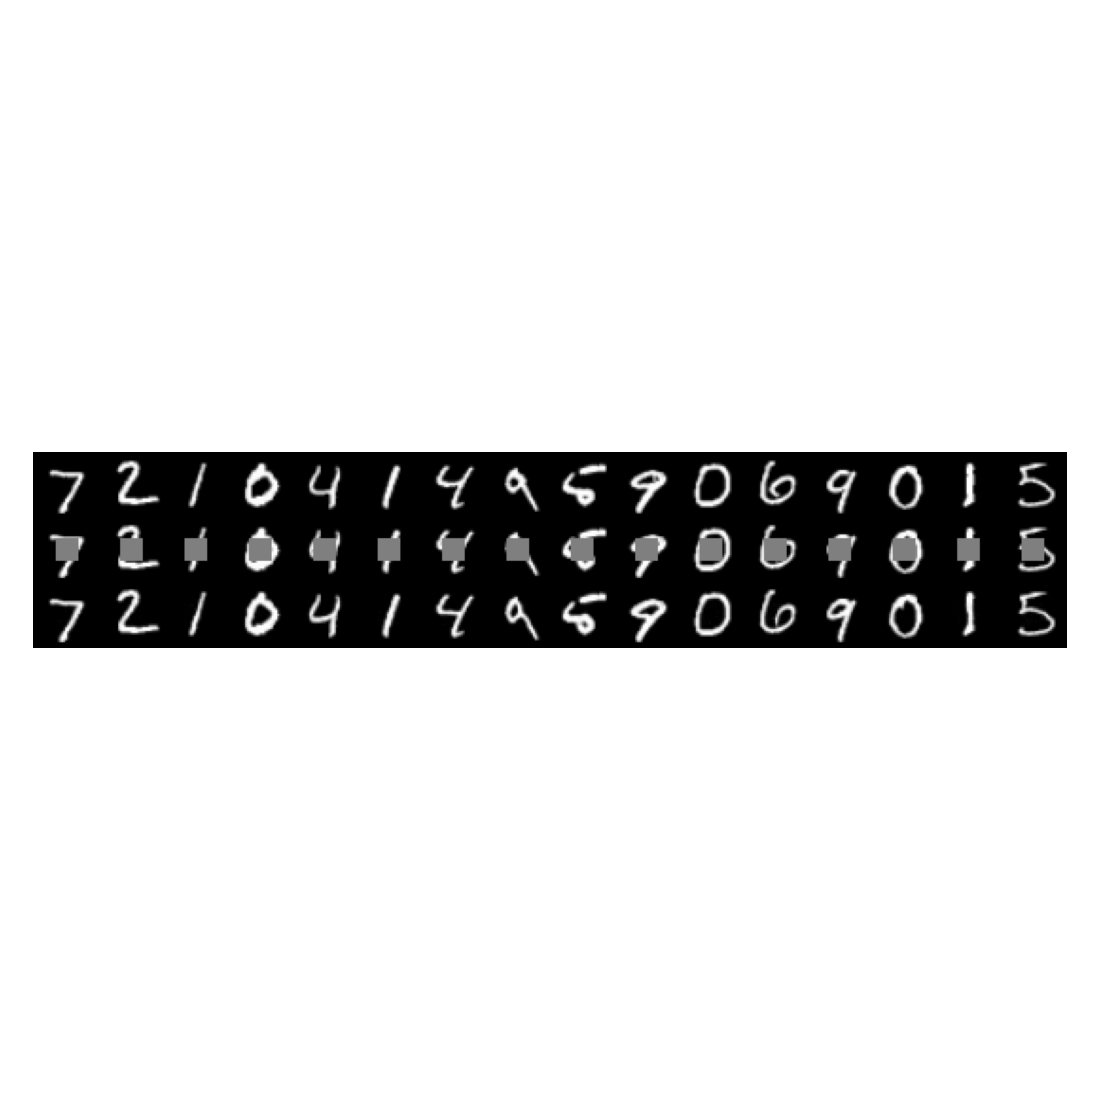

In [7]:

sample_cmd(
    ckpt="outputs/inpaint/last.pt",
    n=16,
    steps=150,                # match train() sample_steps
    center_box=12,
    dc_repeats=3,
    dc_fixed_z=True,
    pred="v",
    self_cond=True,
    init_from_y=True,
    eta=0.0,
    coord_conv=True,
)

from IPython.display import Image, display
display(Image(filename="outputs/inpaint/samples.png"))


## 11. Evaluate _(hole-only PSNR/L1)_

Runs inpainting on the MNIST **test** split up to `n_eval` images, computes **PSNR/L1 over the hole region**, and saves **`results/inpaint_metrics.json`** (also prints the values).

> For fair comparison, match `steps` and `center_box` with training; use `η=0` for deterministic DDIM.


In [8]:
eval_cmd(
    ckpt="outputs/inpaint/last.pt",
    batch_size=256,
    n_eval=500,
    steps=150,                # same DDIM steps
    center_box=12,
    dc_repeats=3,
    dc_fixed_z=True,
    pred="v",
    self_cond=True,
    init_from_y=True,
    eta=0.0,
    coord_conv=True,
    seed=123,
)


{
  "psnr_hole": 14.412980079650879,
  "l1_hole": 0.20122989267110825
}
